# Assignment 3 - Track 2

Luca Miglior - 580671

# Part 1: CNN building

In [8]:
# autoreload external modules
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import conv as utils


BATCH_SIZE = 512

# import CIFAR10 dataset (code from https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# one hot encoding of labels
def one_hot(labels, num_classes):
    return torch.eye(num_classes)[labels]

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# needed for converting labels to strings
label_dict = {}
for i in range(len(classes)):
    label_dict[i] = classes[i]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Files already downloaded and verified
Files already downloaded and verified


## Now, we may want to create a validation set to properly do model selection

Our validation set will be taken from the TR set

In [9]:
train_size = int(0.8 * len(trainset))
val_size = len(trainset) - train_size
trainset, valset = torch.utils.data.random_split(
    trainset, [train_size, val_size], generator=torch.Generator().manual_seed(42)
)

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=BATCH_SIZE, num_workers=0, shuffle=False
)
valloader = torch.utils.data.DataLoader(
    valset, batch_size=BATCH_SIZE, num_workers=0, shuffle=False
)

len(trainloader.dataset.indices), len(valloader.dataset.indices)

(40000, 10000)

In [13]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    unrolld = img.numpy()
    plt.imshow(np.transpose(unrolld, (1, 2, 0)))
    plt.show()

## Model selection

## First try, vanilla CNN with two convolutional layers

As our first attempt, we will try to make the simplest possible CNN with three convolutional layers and two fully connected layers. We will use this architecture as our baseline, then we will try to improve it with some state of the art techniques.

Our first CNN will have the following architecture:

- 3 channel Convolutional layer with 6 filters, kernel size 3x3, stride 1, padding 2
- MaxPool with 2x2 kernel size, stride 1
- ReLU activation

- 6 channel ReLU activated Convolutional layer with 16 filters, kernel size 3x3, stride 1, padding 2
- MaxPool with 2x2 kernel size, stride 1

- Single layer fully connected layer with 576 neurons, softmax activation
- LogSoftmax activation for the MLP (faster convergence during experiments than plain softmax)

In [6]:
class ConvNN(nn.Module):
    def __init__(self):
        super(ConvNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 3)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 6 * 6, 10)
        self.softmax = nn.LogSoftmax(dim=1)
        self.relu = nn.ReLU()

    def forward(self, x):
    
        x = self.pool1(self.relu(self.conv1(x)))
        x = self.pool2(self.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = self.softmax(self.fc1(x))
        return x

### Adam optimizer, learning rate 0.01. Batch size 512 to fully exploit the GPU

In [14]:
model = ConvNN()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
history = []

> NOTE: this cell has been run multiple times: the actual number of epochs is not the one written in the output cell

In [16]:
for i in range(1, 60):
    h = utils.train(
        model, "mps", trainloader, optimizer, criterion, i, val_loader=valloader
    )
    history.append(h)

Epoch    1     | Training Loss: 1.064975     | Training Accuracy: 0.629475     | Validation Loss: 1.153309     | Validation Accuracy: 0.600800
Epoch    2     | Training Loss: 1.057636     | Training Accuracy: 0.632200     | Validation Loss: 1.143558     | Validation Accuracy: 0.604900
Epoch    3     | Training Loss: 1.050374     | Training Accuracy: 0.634825     | Validation Loss: 1.141322     | Validation Accuracy: 0.605400
Epoch    4     | Training Loss: 1.044698     | Training Accuracy: 0.636650     | Validation Loss: 1.138257     | Validation Accuracy: 0.607200
Epoch    5     | Training Loss: 1.041108     | Training Accuracy: 0.638000     | Validation Loss: 1.137437     | Validation Accuracy: 0.609000
Epoch    6     | Training Loss: 1.035273     | Training Accuracy: 0.641600     | Validation Loss: 1.132445     | Validation Accuracy: 0.612300
Epoch    7     | Training Loss: 1.030211     | Training Accuracy: 0.643925     | Validation Loss: 1.130720     | Validation Accuracy: 0.614000

In [17]:
# create dataframe from history
df = pd.DataFrame(
    history, columns=["epoch", "train_loss", "train_acc", "val_loss", "val_acc"]
)
df.head()

,epoch,train_loss,train_acc,val_loss,val_acc
0,1,1.695449,0.393050,1.540596,0.4544
1,2,1.379623,0.512525,1.353875,0.5307
2,3,1.277760,0.549250,1.278463,0.5551
3,4,1.218587,0.573100,1.247009,0.5654
4,5,1.183504,0.585925,1.228151,0.5745


Text(0.5, 1.0, 'Accuracy')

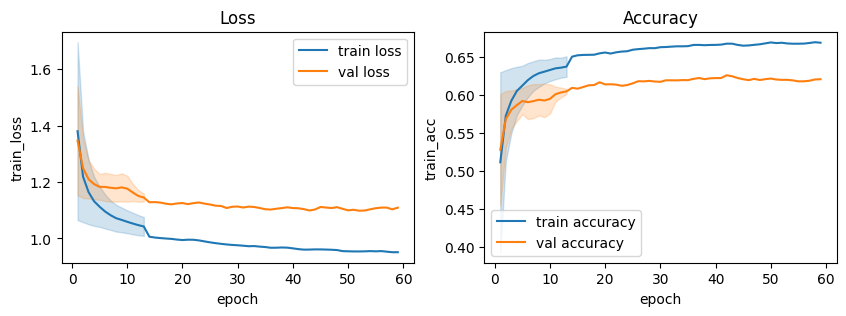

In [18]:
# plot loss and accuracy with subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 3))

sns.lineplot(x="epoch", y="train_loss", data=df, ax=axs[0], label="train loss")
sns.lineplot(x="epoch", y="val_loss", data=df, ax=axs[0], label="val loss")
axs[0].set_title("Loss")

sns.lineplot(x="epoch", y="train_acc", data=df, ax=axs[1], label="train accuracy")
sns.lineplot(x="epoch", y="val_acc", data=df, ax=axs[1], label="val accuracy")
axs[1].set_title("Accuracy")

With this architecture it seems that the model won't learn beyond 62% accuracy on validation set. In fact, after 60 epochs it started overfitting. Let's try to improve it, by adding some regularization techniques.

In particular, i will use the same architecture as before, but with the following changes:
-  A batch normalization layer before the second convolutional layer and before activation (as proposed in [1])
-  Dropout with 0.5 probability before the fully connected layer
-  L2 regularization with 1e-4 weight decay

In [ ]:
class RegConvNN(nn.Module):
    def __init__(self):
        super(RegConvNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 6 * 6, 10)

        self.dropout = nn.Dropout(p=0.5)
        self.softmax = nn.LogSoftmax(dim=1)
        self.relu = nn.ReLU()

        self.bn = nn.BatchNorm2d(6)
        self.bn2 = nn.BatchNorm2d(16)

    def forward(self, x):
        x = self.relu(self.bn(self.conv1(x)))
        x = self.pool(x)

        x = self.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)

        x = torch.flatten(x, 1)
        x = self.softmax(self.fc1(x))
        return x


reg_model = RegConvNN()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(reg_model.parameters(), lr=0.01, weight_decay=1e-4)
reg_history = []

# giving more epochs due to regularization
for i in range(1, 80):
    h = utils.train(
        reg_model, "mps", trainloader, optimizer, criterion, i, val_loader=valloader
    )
    reg_history.append(h)

Text(0.5, 1.0, 'Accuracy')

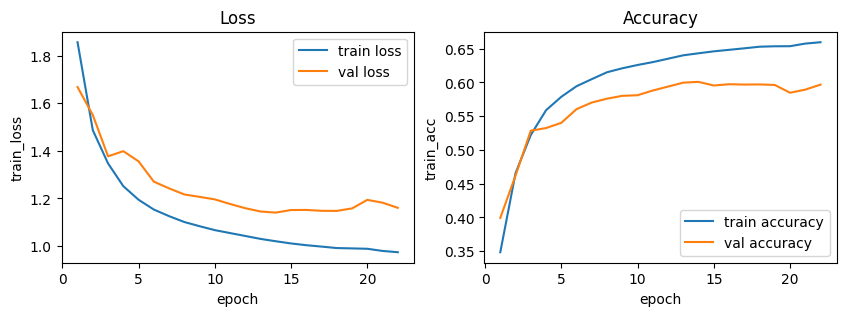

In [20]:
df = pd.DataFrame(
    reg_history, columns=["epoch", "train_loss", "train_acc", "val_loss", "val_acc"]
)

fig, axs = plt.subplots(1, 2, figsize=(10, 3))

sns.lineplot(x="epoch", y="train_loss", data=df, ax=axs[0], label="train loss")
sns.lineplot(x="epoch", y="val_loss", data=df, ax=axs[0], label="val loss")
axs[0].set_title("Loss")

sns.lineplot(x="epoch", y="train_acc", data=df, ax=axs[1], label="train accuracy")
sns.lineplot(x="epoch", y="val_acc", data=df, ax=axs[1], label="val accuracy")
axs[1].set_title("Accuracy")

## With regularization model overfits again.

It seems we need more advanced techniques, as well as more complexity. Building blocks are useful and should be exploited. In this sense, our next model will be built in a compositional fashion. We assessed that BatchNormalization and Dropout worked well, and i will consider them as building blocks for the next model.

One block will be composed by:
- n channels Convolutional layer with p filters, kernel size 3x3
- BatchNormalization before activation, as suggested in [1]
- MaxPool with 2x2 kernel size, stride 1
- Dropout to the next block

The number of filters will progressively increase. I will start from 32 filters, then i will double the number of filters at each block. The last block will have 128 filters.

In [5]:
class BlockCNN(nn.Module):
    def __init__(self):
        super(BlockCNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)  # padding to keep size
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.conv3 = nn.Conv2d(64, 128, 3)

        # MLP classifier
        self.fc1 = nn.Linear(128 * 2 * 2, 128)
        self.fc2 = nn.Linear(128, 10)

        self.softmax = nn.LogSoftmax(dim=1)
        self.relu = nn.ReLU()

        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)

        self.dropout = nn.Dropout(p=0.6)
        self.pool = nn.MaxPool2d(2, 2)

    def forward(self, x):
        # first block
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.dropout(self.pool(x))

        # second block
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.dropout(self.pool(x))

        # third block
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.dropout(self.pool(x))

        x = torch.flatten(x, 1)
        x = self.relu(self.fc1(x))
        x = self.softmax(self.fc2(x))
        return x

In [22]:
block_model = BlockCNN()
print(block_model)

BlockCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=512, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (softmax): LogSoftmax(dim=1)
  (relu): ReLU()
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)


In [ ]:
criterion = torch.nn.CrossEntropyLoss()
# giving more L2 regularization strength
optimizer = torch.optim.Adam(block_model.parameters(), lr=0.001, weight_decay=1e-4)
history = []

for i in range(1, 101):
    h = utils.train(
        block_model, "mps", trainloader, optimizer, criterion, i, val_loader=valloader
    )
    history.append(h)

> NOTE: training logging removed from now to the end of the assignment for ease of reading.
> Learning curves reported after each model

Text(0.5, 1.0, 'Accuracy')

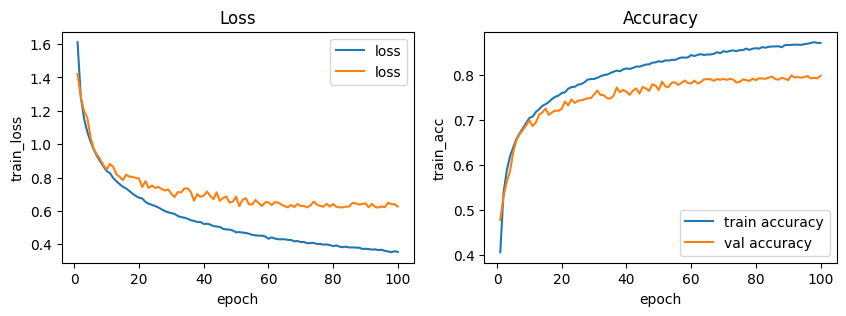

In [24]:
df = pd.DataFrame(
    history, columns=["epoch", "train_loss", "train_acc", "val_loss", "val_acc"]
)
df.head()

fig, axs = plt.subplots(1, 2, figsize=(10, 3))

sns.lineplot(x="epoch", y="train_loss", data=df, ax=axs[0], label="loss")
sns.lineplot(x="epoch", y="val_loss", data=df, ax=axs[0], label="loss")
axs[0].set_title("Loss")

sns.lineplot(x="epoch", y="train_acc", data=df, ax=axs[1], label="train accuracy")
sns.lineplot(x="epoch", y="val_acc", data=df, ax=axs[1], label="val accuracy")
axs[1].set_title("Accuracy")

### OK! Accuracy improved dramatically, now we are around 80% on validation set.
From the above picture and from the training log, we can see that the model is about to overfit.

## Residual Connections

For our next experiments, let's add resitual connections [2] from the input to the output of each block. This will help the model to learn faster and hopefully it will avoid losing of information during the training.

In [ ]:
class ResBNet(nn.Module):
    def __init__(self):
        super(ResBNet, self).__init__()

        # first convolutional layers
        self.conv1 = nn.Conv2d(3, 32, 5)
        self.conv2 = nn.Conv2d(32, 32, 5)

        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)   # padding to keep size
        self.conv4 = nn.Conv2d(64, 64, 3, padding=1)

        self.conv5 = nn.Conv2d(64, 128, 3, padding=1)  # same
        self.conv6 = nn.Conv2d(128, 128, 3, padding=1)

        self.conv1x1_1 = nn.Conv2d(32, 64, 1)
        self.conv1x1_2 = nn.Conv2d(64, 128, 1)

        # MLP classifier
        self.fc1 = nn.Linear(1152, 256)
        self.fc2 = nn.Linear(256, 10)

        self.softmax = nn.LogSoftmax(dim=1)
        self.relu = nn.ReLU()

        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)
        self.bn4 = nn.BatchNorm2d(64)
        self.bn5 = nn.BatchNorm2d(128)
        self.bn6 = nn.BatchNorm2d(128)

        self.dropout = nn.Dropout(p=0.5)
        self.pool = nn.MaxPool2d(2, 2)
        self.mean_pool = nn.AvgPool2d(2, 2)

    def forward(self, x):
        # make a residual connected forward pass
        # first block
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.dropout(x)
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.dropout(self.pool(x))

        # second block with residual connection
        res = self.conv1x1_1(
            x                                 # residual connection, 1x1 conv trick to match dimensions
        )  
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.dropout(x)
        x = self.relu(self.bn4(self.conv4(x)))
        x = x + res
        x = self.dropout(self.pool(x))

        # third block
        res = self.conv1x1_2(                 # residual connection, 1x1 conv trick to match dimensions
            x
        )
        x = self.relu(self.bn5(self.conv5(x)))
        x = self.dropout(x)
        x = self.relu(self.bn6(self.conv6(x)))
        x = x + res
        x = self.dropout(self.mean_pool(x))

        x = torch.flatten(x, 1)
        x = self.relu(self.fc1(x))
        x = self.softmax(self.fc2(x))

        return x

In [ ]:
model = ResBNet()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
history = []

for i in range(1, 101):
    h = utils.train(
        model, "mps", trainloader, optimizer, criterion, i, val_loader=valloader
    )
    history.append(h)

<Axes: xlabel='epoch', ylabel='train_acc'>

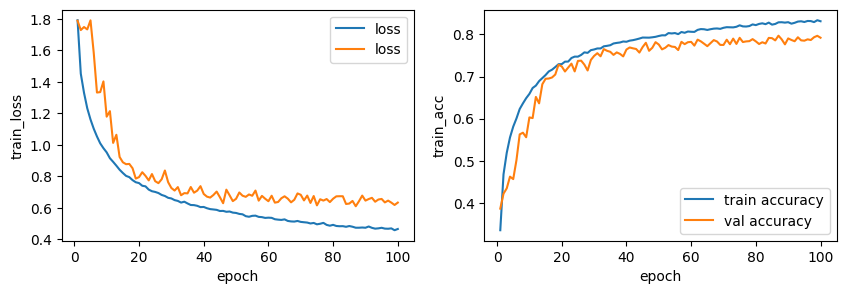

In [31]:
df = pd.DataFrame(
    history, columns=["epoch", "train_loss", "train_acc", "val_loss", "val_acc"]
)
df.head()

fig, axs = plt.subplots(1, 2, figsize=(10, 3))

sns.lineplot(x="epoch", y="train_loss", data=df, ax=axs[0], label="loss")
sns.lineplot(x="epoch", y="val_loss", data=df, ax=axs[0], label="loss")

sns.lineplot(x="epoch", y="train_acc", data=df, ax=axs[1], label="train accuracy")
sns.lineplot(x="epoch", y="val_acc", data=df, ax=axs[1], label="val accuracy")

### Increasing model complexity and adding residual connections did not help, we are still around 80% accuracy on validation set.

## We may need to boost the model with data augmentation

In [11]:
# this is the same as the first cell.
transform_augmentation = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(p=0.5),  # randomly flip
        transforms.RandomRotation(10),  # random rotation
        transforms.RandomAffine(
            0, shear=10, scale=(0.8, 1.2)
        ),  # random affine transformation
        transforms.ToTensor(),  # convert to tensor to feed into model
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # normalize
    ]
)

trainset_aug = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform_augmentation
)
# we already have validation and test sets, with the same transformations. We just remove the validation images from this new training set
trainset_aug.data = np.delete(trainset_aug.data, valloader.dataset.indices, axis=0)
trainset_aug.targets = np.delete(
    trainset_aug.targets, valloader.dataset.indices, axis=0
)

# data loader
trainloader_aug = torch.utils.data.DataLoader(
    trainset, batch_size=BATCH_SIZE, num_workers=0, shuffle=False
)

Files already downloaded and verified


### Now, at each epoch, training set is augmented randomly according to the above transformations.
Let's see if this helps the previous block model, not the residual one.
I will also increase model complexity, adding a fourth convolutional layer with 256 filters.
Padding is necessary to keep image size and avoid loosing too much of the image.

In [5]:
# the final chosen model
class BlockCNN(nn.Module):
    # define sequential model
    def __init__(self):
        super(BlockCNN, self).__init__()

        # first convolutional layers
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)  # padding to keep size
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, 3)          # no padding
        # MLP classifier
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 10)

        self.softmax = nn.LogSoftmax(dim=1)
        self.relu = nn.ReLU()

        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(256)

        self.dropout = nn.Dropout(p=0.3)
        self.pool = nn.MaxPool2d(2, 2)

    def forward(self, x):
        # first block
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.dropout(self.pool(x))

        # second block
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.dropout(self.pool(x))

        # third block
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.dropout(self.pool(x))

        # fourth block
        x = self.relu(self.bn4(self.conv4(x)))
        x = self.dropout(self.pool(x))

        x = torch.flatten(x, 1)
        x = self.relu(self.fc1(x))
        x = self.softmax(self.fc2(x))
        return x

In [ ]:
model = BlockCNN()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
history = []

for i in range(1, 131):
    h = utils.train(
        model, "mps", trainloader_aug, optimizer, criterion, i, val_loader=valloader
    )
    history.append(h)

<Axes: xlabel='epoch', ylabel='train_acc'>

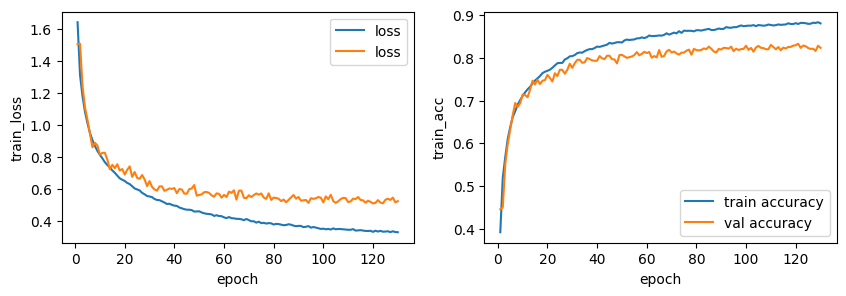

In [26]:
# create dataframe from history
df = pd.DataFrame(
    history, columns=["epoch", "train_loss", "train_acc", "val_loss", "val_acc"]
)

fig, axs = plt.subplots(1, 2, figsize=(10, 3))

sns.lineplot(x="epoch", y="train_loss", data=df, ax=axs[0], label="train loss")
sns.lineplot(x="epoch", y="val_loss", data=df, ax=axs[0], label="loss")

sns.lineplot(x="epoch", y="train_acc", data=df, ax=axs[1], label="train accuracy")
sns.lineplot(x="epoch", y="val_acc", data=df, ax=axs[1], label="val accuracy")

In [34]:
df.sort_values(by="val_loss", ascending=True).head(5)

,epoch,train_loss,train_acc,val_loss,val_acc
119,120,0.329667,0.880850,0.508146,0.8292
123,124,0.330914,0.880800,0.509003,0.8270
120,121,0.336923,0.879000,0.511312,0.8328
104,105,0.345866,0.876500,0.511377,0.8277
93,94,0.365780,0.870125,0.511401,0.8260


Our target loss is 0.3296. Let's retrain on the whole training set.

In [ ]:
# train on full training set, without validation split and with data augmentation
trainset = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform_augmentation
)
trainloader_full = torch.utils.data.DataLoader(
    trainset, batch_size=BATCH_SIZE, num_workers=0, shuffle=False
)

# create model, loss function and optimizer

TARGET_LOSS = 0.3296

model = BlockCNN()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
history = []

train_loss = torch.inf
i = 0
while train_loss > TARGET_LOSS:
    h = utils.train(
        model, "mps", trainloader_full, optimizer, criterion, i, val_loader=valloader
    )  # val loader is not actually used since now is a subset of tr set
    history.append(h)
    train_loss = h["train_loss"]
    i += 1

In [41]:
# test
test_loss, test_acc = utils.test(model, "mps", testloader, criterion, 1)
print(f"Test Loss: {test_loss:.3f} | Test Accuracy: {test_acc:.3f}")

Test Loss: 0.469 | Test Accuracy: 0.838


## Classification analysis

  0%|          | 0/20 [00:00<?, ?it/s]

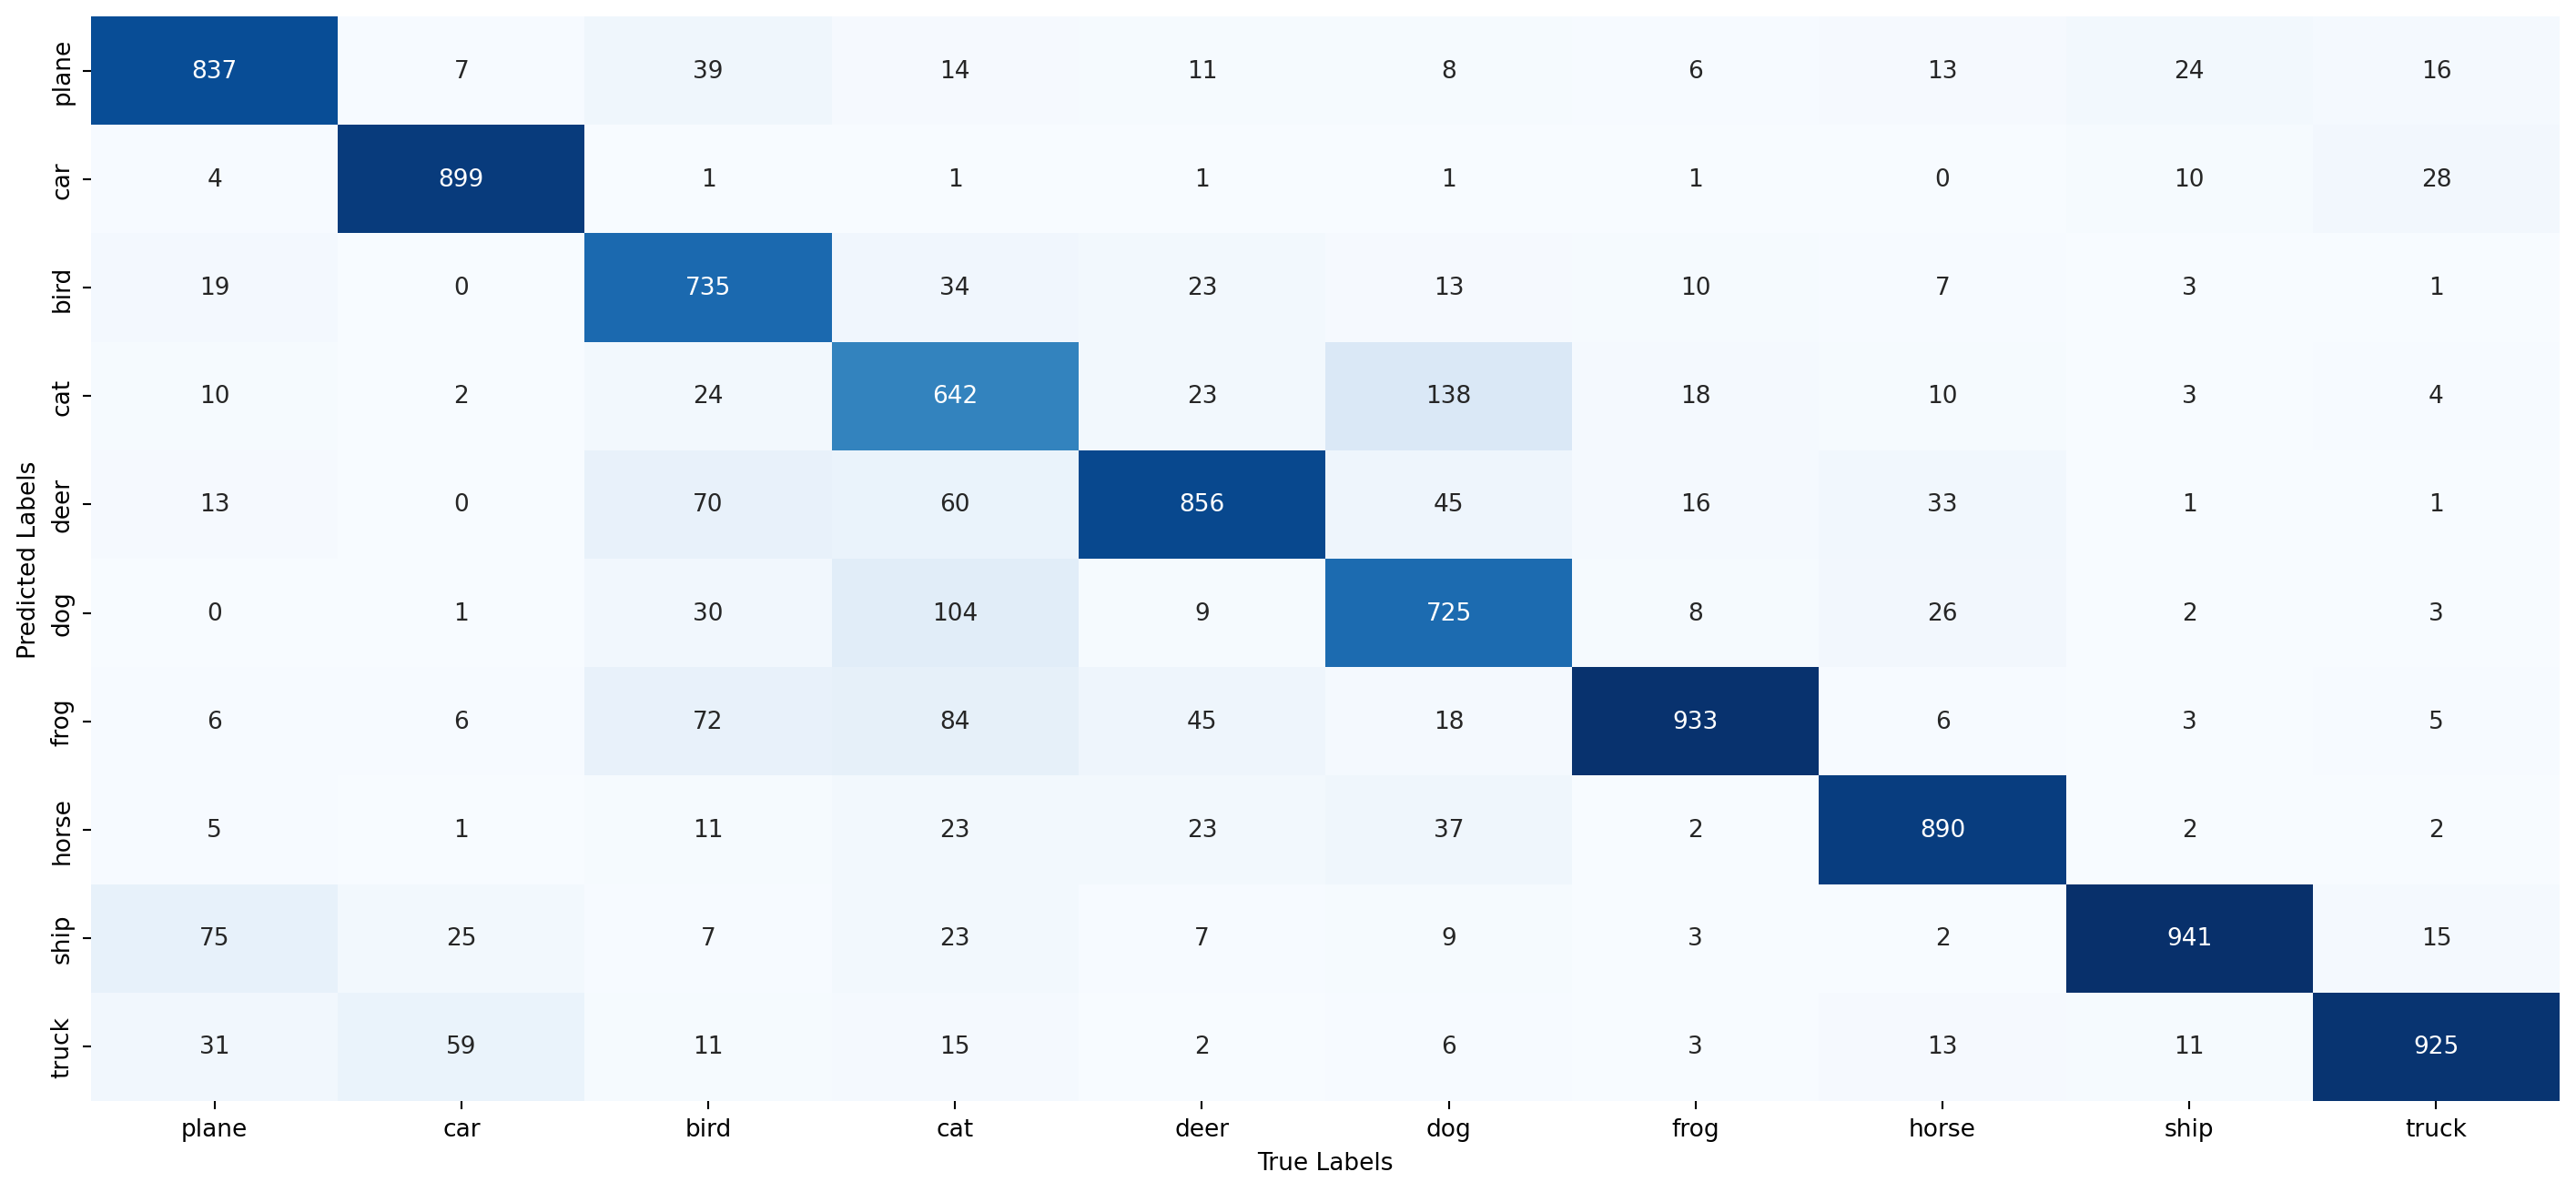

In [12]:
model.eval()  # we do not want dropout in testing :)
preds = []
labels = []
for images, labels_batch in testloader:
    preds_batch = model(images)
    preds.append(preds_batch.detach().numpy())
    labels.append(labels_batch.detach().numpy())

preds = np.concatenate(preds)
labels = np.concatenate(labels)


preds = np.argmax(preds, axis=1)
labels = np.array(labels)
confusion_matrix = np.zeros((10, 10))
for i in range(len(preds)):
    confusion_matrix[preds[i], labels[i]] += 1

plt.figure(figsize=(15, 7), dpi=190)
sns.heatmap(
    confusion_matrix,
    annot=True,
    fmt=".0f",
    cmap="Blues",
    cbar=False,
    xticklabels=classes,
    yticklabels=classes,
)
plt.xlabel("True Labels")
plt.ylabel("Predicted Labels")
plt.tight_layout()
plt.show()

Confusion matrix above shows a predominant diagonal structure, which is good. We can see some misclassifications between cat and dogs (and vice versa) which makes sense, and we were expecting this. We also were expecting some misclassifications between trucks and cars, but the model performs well in this sense.

In [ ]:
# save model
torch.save(model.state_dict(), "model.pth")

In [23]:
from torchinfo import summary
import warnings

warnings.filterwarnings("ignore")

summary(model, input_size=(1, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
BlockCNN                                 [1, 10]                   --
├─Conv2d: 1-1                            [1, 32, 32, 32]           896
├─BatchNorm2d: 1-2                       [1, 32, 32, 32]           64
├─ReLU: 1-3                              [1, 32, 32, 32]           --
├─MaxPool2d: 1-4                         [1, 32, 16, 16]           --
├─Dropout: 1-5                           [1, 32, 16, 16]           --
├─Conv2d: 1-6                            [1, 64, 16, 16]           18,496
├─BatchNorm2d: 1-7                       [1, 64, 16, 16]           128
├─ReLU: 1-8                              [1, 64, 16, 16]           --
├─MaxPool2d: 1-9                         [1, 64, 8, 8]             --
├─Dropout: 1-10                          [1, 64, 8, 8]             --
├─Conv2d: 1-11                           [1, 128, 8, 8]            73,856
├─BatchNorm2d: 1-12                      [1, 128, 8, 8]            256
├─Re

## Conclusions thoughts and on the model selection phase

We started from a simple CNN with two small convolutional layers and kept adding more regularization and complexity. We ended up with a model with four convolutional layers and 256 filters, with batch normalization at each level and dropout, for a total of 423,562 parameters and a size of 2.64MB. On this simple setup, we also tried to add residual connections. Honestly, I was expecting better performance from this technique, but i did not see any significant improvement. One possible reason is that the model is not deep enough to appreciate the benefits of residual connections. We then decided to add more complexity to the block cnn, by adding a convolutional layer, preferring computational efficiency over depth and complexity. The final model performed better, also thanks to data augmentation. This technique helped avoiding overfitting and improved the model performance. Unfortunately, we are still far from the state of the art, but with limited resources and time, this is the best we could do, and we think it is still a good result for this course assignment, representing also a good compromise among model size and accuracy.

# Part 2: applying grey patches on various images and see performance of the model

For this test, we will pick two images that are correctly classified for each class (we want 100% accuracy on them). Then we will try to put a neutral grey (0.5) on each image, in differen positions and different sizes, and see how the model behaves. 

In [6]:
# load model
from conv import BlockCNN

model = BlockCNN()
model.load_state_dict(torch.load("model.pth"))
model.eval()

BlockCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (softmax): LogSoftmax(dim=1)
  (relu): ReLU()
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [10]:
def apply_grey_patch(img, x_start, y_start, patch_size=3, patch_value=0.5):
    img = np.array(img)
    # check if out of bounds
    if x_start + patch_size > img.shape[1] or y_start + patch_size > img.shape[2]:
        patch_size = min(img.shape[1] - x_start, img.shape[2] - y_start)
        # warn user
        print(f"Patch size out of bounds. Patch size is now {patch_size}")

    img[
        :, x_start : x_start + patch_size, y_start : y_start + patch_size
    ] = patch_value  # 0.5 sincee we have normalized the image. 0.5 on all channels will result in a grey patch
    return img


def imshow(img):
    img = img / 2 + 0.5
    unrolld = img.numpy()
    plt.imshow(np.transpose(unrolld, (1, 2, 0)))
    plt.show()

In the following cell, there is an example of the patches to be applied on the images. The above defined utility function will apply the patch on the selected location, building a square of the desired size. It is also possible to change patch's color programmatically.

/var/folders/h3/td18b9zd6nx0r50mw9g7nr8w0000gn/T/ipykernel_74963/2902618500.py:14: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:248.)
  imshow(torchvision.utils.make_grid(torch.tensor(images)))


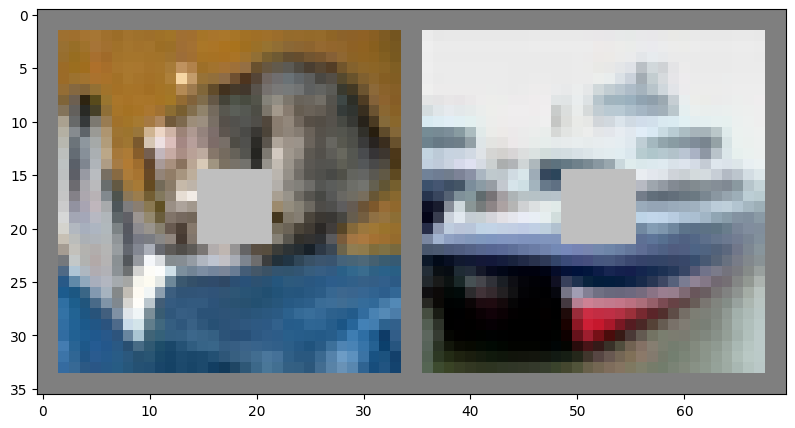

In [11]:
# take two different images from the test set and add a grey patch to them
# this is to check if the model is actually looking at the right part of the image

images = []
labels = []
for i in range(2):
    img, label = apply_grey_patch(testset[i][0], 13, 13, 7), testset[i][1]
    images.append(img)
    labels.append(label)

# show images
plt.figure(figsize=(10, 5))

imshow(torchvision.utils.make_grid(torch.tensor(images)))

### Getting 25 images for each class that are correctly classified

We will try to see how patches in different positions can affect accuracy. We will use the following positions:
- top left
- top right
- bottom left
- bottom right
- center
- left center
- right center

We will take 25 images for each class that are correctly classified, and we will apply the above patches on them. We will then see how the model behaves.

In [9]:
images = []
labels = []
placeholder = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

# taking only the correctly classified images
for i in range(len(testset)):
    img, label = testset[i][0], testset[i][1]
    if placeholder[label] < 25:
        if label == np.argmax(model(img.unsqueeze(0)).detach().numpy()):
            images.append(img)
            labels.append(label)
            placeholder[label] += 1

In [15]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    unrolld = img.numpy()
    plt.imshow(np.transpose(unrolld, (1, 2, 0)))
    plt.show()


def apply_grey_patch(img, x, y, patch_size):
    """
    Applies a grey patch to an image at the given coordinates with the given size.
    Args:
        img (torch.tensor): image to apply patch to
        x (int): x coordinate of the patch
        y (int): y coordinate of the patch
        patch_size (int): size of the patch
    Returns:
        img (torch.tensor): image with patch applied
    """

    img = np.array(img)
    # check if out of bounds
    if x + patch_size > img.shape[1] or y + patch_size > img.shape[2]:
        patch_size = min(img.shape[1] - x, img.shape[2] - y)
        # warn user
        print(f"Patch size out of bounds. Patch size is now {patch_size}")

    img[
        :, x : x + patch_size, y : y + patch_size
    ] = 0.5  # 0.5 since we normalized the image. 0.5 on all channels will result in a grey patch
    return img


def apply_rectangular_patch(img, x, y, width, height):
    """
    Applies a grey patch to an image at the given coordinates with the given size.
    Args:
        img (torch.tensor): image to apply patch to
        x (int): x coordinate of the patch
        y (int): y coordinate of the patch
        width (int): width of the patch
        height (int): height of the patch
    Returns:
        img (torch.tensor): image with patch applied
    """
    img = np.array(img)
    # check if out of bounds
    if x + width > img.shape[1] or y + height > img.shape[2]:
        width = min(img.shape[1] - x, width)
        height = min(img.shape[2] - y, height)
        # warn user
        print(f"Patch size out of bounds. Patch size is now {width}x{height}")

    img[:, x : x + width, y : y + height] = 0.5
    return img


def compute_patch_accuracy(images, sizes, x, y, model):
    """
    Computes the accuracy of a model on a set of images with a patch applied.
    Args:
        images (torch.tensor): images to compute accuracy on
        sizes (list): list of patch sizes to apply
        x (int): x coordinate of the patch
        y (int): y coordinate of the patch
        model (torch.nn.Module): model to compute accuracy on
    Returns:
        accuracies (list): list of accuracies for each patch size
    """
    accuracies = []
    for size in sizes:
        correct = 0
        patched_images = torch.tensor(
            [apply_grey_patch(img, x, y, size) for img in images]
        )
        for sample in zip(patched_images, labels):
            prediction_label = label_dict[
                np.argmax(model(sample[0].unsqueeze(0)).detach().numpy())
            ]
            actual_label = label_dict[sample[1]]
            if prediction_label == actual_label:
                correct += 1
        accuracies.append(correct / len(images))

    return accuracies

/var/folders/h3/td18b9zd6nx0r50mw9g7nr8w0000gn/T/ipykernel_76077/1251859071.py:28: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:248.)
  patched_images = torch.tensor([apply_grey_patch(img, x, y, size) for img in images])


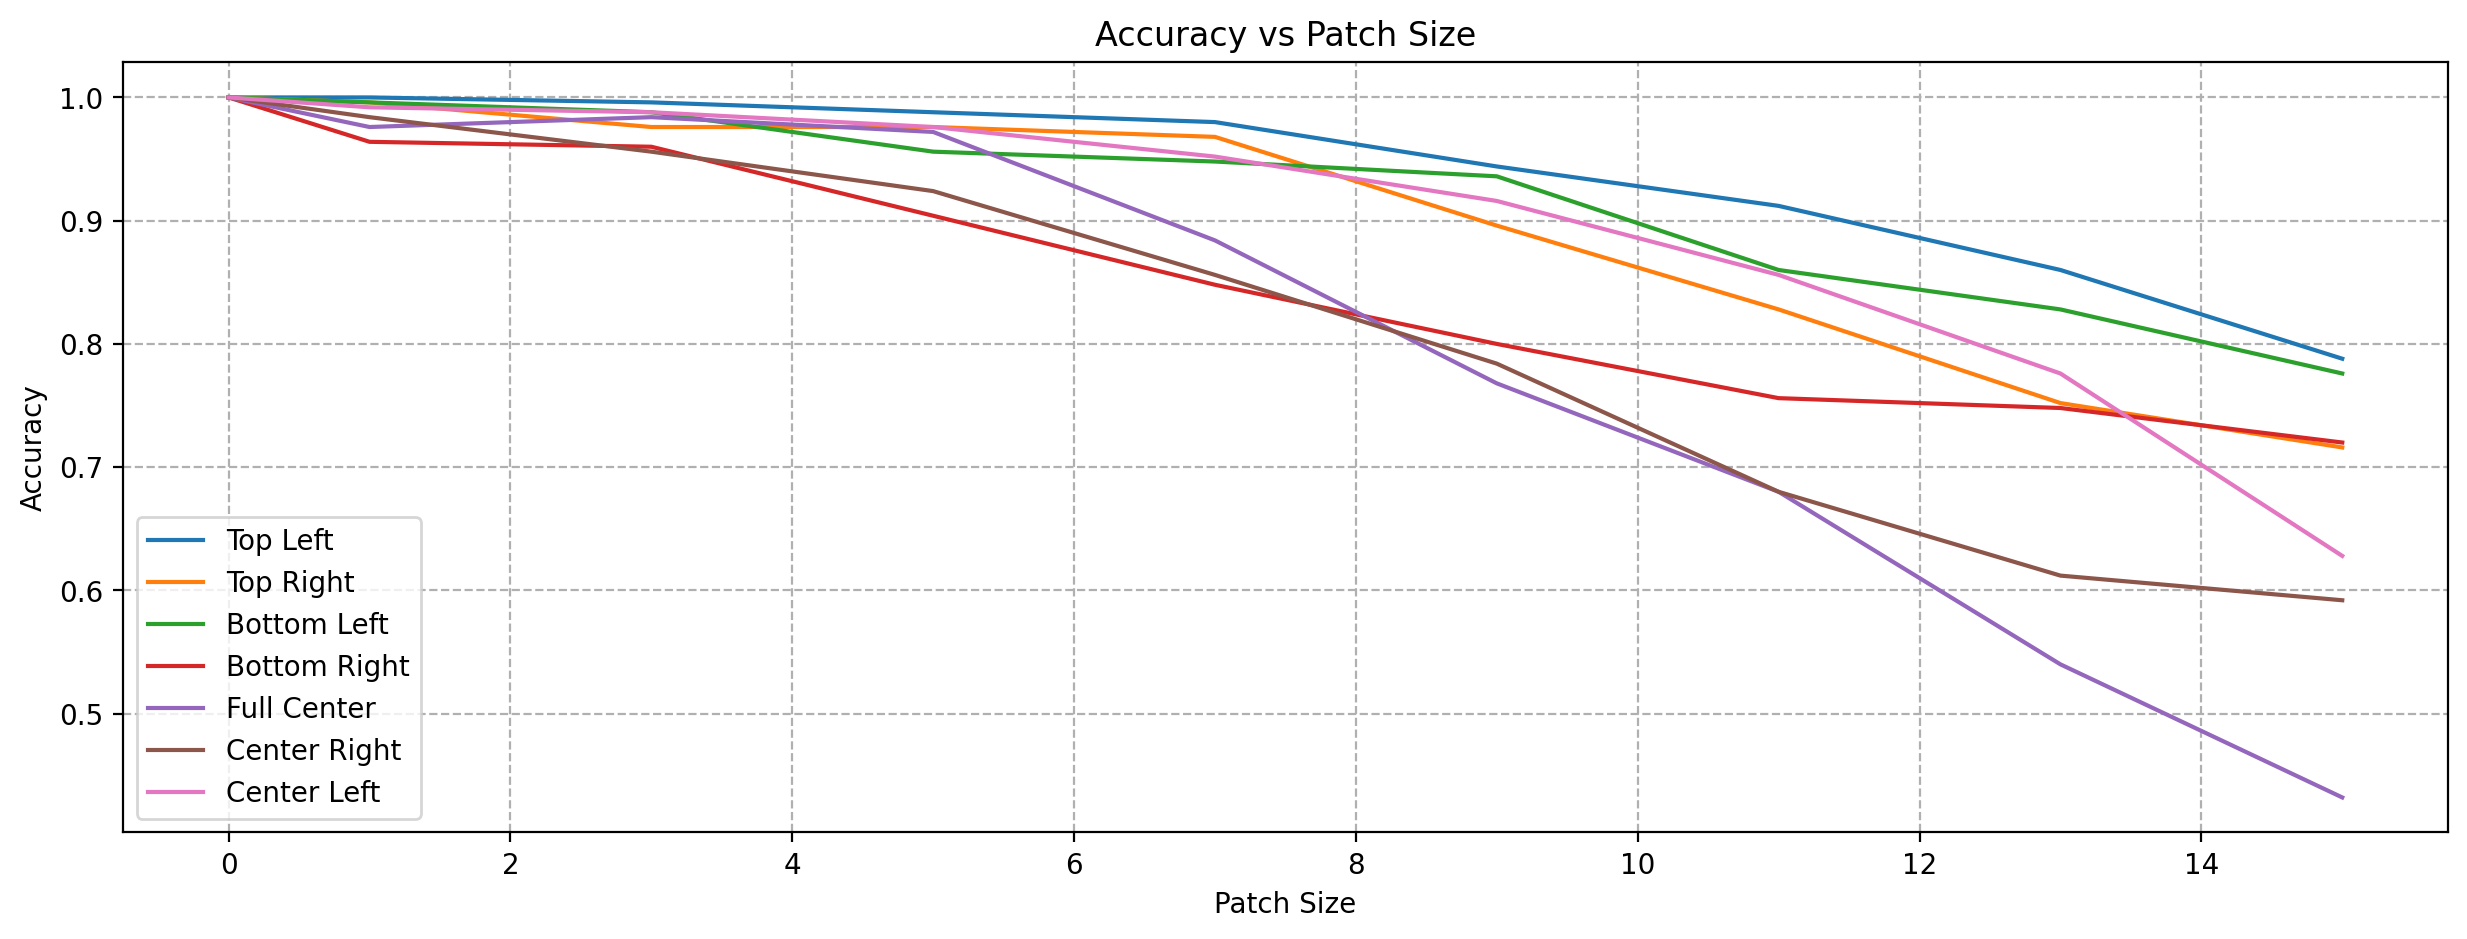

In [11]:
patch_sizes = [0] + [i for i in range(0, 16) if i % 2 == 1]
top_left_accuracies = compute_patch_accuracy(images, patch_sizes, 0, 0, model)
top_right_accuracies = compute_patch_accuracy(images, patch_sizes, 0, 15, model)
bottom_left_accuracies = compute_patch_accuracy(images, patch_sizes, 15, 0, model)
bottom_right_accuracies = compute_patch_accuracy(images, patch_sizes, 15, 15, model)
center_accuracies = compute_patch_accuracy(images, patch_sizes, 7, 7, model)
center_right_accuracies = compute_patch_accuracy(images, patch_sizes, 7, 15, model)
center_left_accuracies = compute_patch_accuracy(images, patch_sizes, 7, 0, model)

plt.figure(dpi=200, figsize=(15, 5))
# plot with seaborn with different style and color for each location
sns.lineplot(x=patch_sizes, y=top_left_accuracies, label="Top Left")
sns.lineplot(x=patch_sizes, y=top_right_accuracies, label="Top Right")
sns.lineplot(x=patch_sizes, y=bottom_left_accuracies, label="Bottom Left")
sns.lineplot(x=patch_sizes, y=bottom_right_accuracies, label="Bottom Right")
sns.lineplot(x=patch_sizes, y=center_accuracies, label="Full Center")
sns.lineplot(x=patch_sizes, y=center_right_accuracies, label="Center Right")
sns.lineplot(x=patch_sizes, y=center_left_accuracies, label="Center Left")

plt.xlabel("Patch Size")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Patch Size")
plt.grid(True, linestyle="--")
plt.legend(title="Patch Location")
plt.legend()

From the above chart we can see that the model is quite robust to noise and accuracy is little affected by the patch size until 5x5 (25px, 2,45% of total image's pixels) size. After that, accuracy drops dramatically. However, it is clear how patch location is important: as suggested by intuition accuracy is less affected when the patch is located on the margins (see the orange line, top right which maintains 100% accuracy until 7x7 patches).

### Manually apply patches on selected images

In the following cell, we will manually select patch position and size, and we will apply it on the selected image. We will then see how the model behaves. With this approach, we can see what are the main features, for each class, that the model is looking at during classification: for instance, we expect that in dog/cat classification, a patch over nose/eyes/ears will be determinant for the succcess of the task; same for wheels in cars and trucks.

In [74]:
# using this because we want to shuffle data and this is the fastest way with torch datasets
torch.manual_seed(443)
testloader = torch.utils.data.DataLoader(testset, shuffle=True)
placeholder = [0 for i in range(10)]  # keep the count
images = {k: [] for k in label_dict.values()}

# now using testloader to get the images
for img, label in testloader:
    label = label.item()
    if placeholder[label] < 2:
        if label == np.argmax(model(img).detach().numpy()):
            images[label_dict[label]].append(img.squeeze(0))
            placeholder[label] += 1

### Patch on cat images

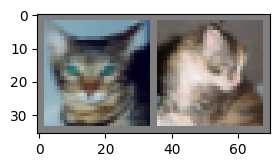

Cat 1: 0.974 | Cat 2: 0.839


In [75]:
plt.figure(figsize=(3, 2))
cats = images["cat"]
imshow(torchvision.utils.make_grid(images["cat"]))

# feed the first image to the model and get the output
cat1 = float(torch.exp(torch.max(model(cats[0].unsqueeze(0)))).detach().numpy())
cat2 = float(torch.exp(torch.max(model(cats[1].unsqueeze(0)))).detach().numpy())

print(f"Cat 1: {cat1:.3f} | Cat 2: {cat2:.3f}")

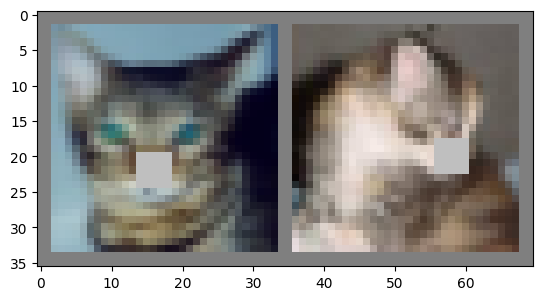

Cat 1: 0.974 | Cat 1 Patch: 0.979
Cat 2: 0.839 | Cat 2 Patch: 0.827


In [142]:
# apply patch on center of cat1
cat1_patch = apply_grey_patch(cats[0], 18, 12, 5)
cat2_patch = apply_grey_patch(cats[1], 16, 20, 5)
imshow(torchvision.utils.make_grid(torch.tensor([cat1_patch, cat2_patch])))
# get model output
cat1_patch = float(
    torch.exp(torch.max(model(torch.tensor(cat1_patch).unsqueeze(0)))).detach().numpy()
)
cat2_patch = float(
    torch.exp(torch.max(model(torch.tensor(cat2_patch).unsqueeze(0)))).detach().numpy()
)
print(f"Cat 1: {cat1:.3f} | Cat 1 Patch: {cat1_patch:.3f}")
print(f"Cat 2: {cat2:.3f} | Cat 2 Patch: {cat2_patch:.3f}")

Wow! Maybe the nose is not important in the first image, in fact the probability of that cat being a cat increased.
In the second image, the cat is seen from the profile and the patch is on the nose, so the model is not able to classify it anymore with the same certainty.

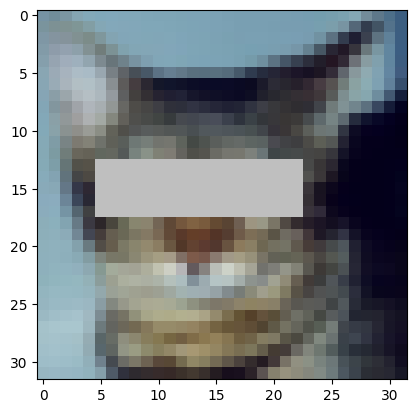

Cat 1: 0.974 | Cat 1 Patch: 0.483, model prediction: cat


In [124]:
# apply patch on center of cat1
cat1_patch = apply_rectangular_patch(cats[0], 13, 5, 5, 18)

imshow(torchvision.utils.make_grid(torch.tensor([cat1_patch])))

prediction = model(torch.tensor(cat1_patch).unsqueeze(0))
prediction_label = label_dict[np.argmax(prediction.detach().numpy())]
cat1_patch = float(
    torch.exp(torch.max(model(torch.tensor(cat1_patch).unsqueeze(0)))).detach().numpy()
)
print(
    f"Cat 1: {cat1:.3f} | Cat 1 Patch: {cat1_patch:.3f}, model prediction: {prediction_label}"
)

Now, with the eyes covered, the model is not so sure about the prediction. It still thinks it is a cat, but with a lower probability. Let's try with the ears.

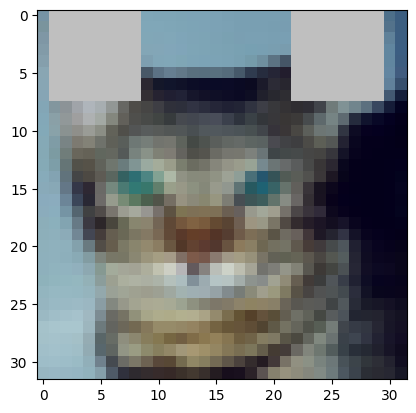

Cat 1: 0.974 | Cat 1 Patch: 0.783 | model prediction: cat


In [162]:
# apply patch on center of cat1
cat1_patch = apply_grey_patch(cats[0], 0, 1, 8)
cat1_patch = apply_grey_patch(cat1_patch, 0, 22, 8)

imshow(torchvision.utils.make_grid(torch.tensor([cat1_patch])))
# get model output
prediction = model(torch.tensor(cat1_patch).unsqueeze(0))
# get prediction label
prediction_label = label_dict[np.argmax(prediction.detach().numpy())]
cat1_patch = float(
    torch.exp(torch.max(model(torch.tensor(cat1_patch).unsqueeze(0)))).detach().numpy()
)
print(
    f"Cat 1: {cat1:.3f} | Cat 1 Patch: {cat1_patch:.3f} | model prediction: {prediction_label}"
)

Slightly low probability, but still a cat, for sure. We can tell the model is quite robust to noise in case of cats. The patch on the eyes was the one putting the model in trouble.

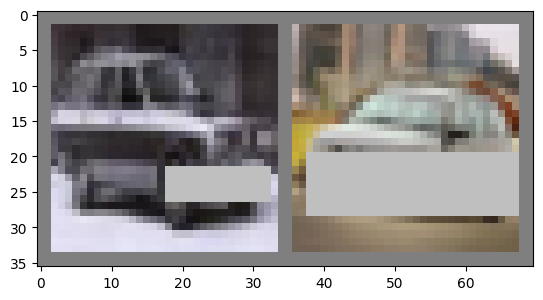

Car 1: 0.974 | Car 1 Patch: 0.782 | prediction car
Car 2: 0.998 | Car 2 Patch: 0.531 | prediction ship


In [219]:
cars = images["car"]
car1 = float(torch.exp(torch.max(model(cars[0].unsqueeze(0)))).detach().numpy())
car2 = float(torch.exp(torch.max(model(cars[1].unsqueeze(0)))).detach().numpy())

# apply patch on center of car1
car1_patch = apply_rectangular_patch(cars[0], 20, 16, 5, 15)
car2_patch = apply_rectangular_patch(cars[1], 18, 2, 9, 30)

imshow(torchvision.utils.make_grid(torch.tensor([car1_patch, car2_patch])))

car1_patch_prob = float(
    torch.exp(torch.max(model(torch.tensor(car1_patch).unsqueeze(0)))).detach().numpy()
)
car1_patch_label = label_dict[
    np.argmax(model(torch.tensor(car1_patch).unsqueeze(0)).detach().numpy())
]

car2_patch_prob = float(
    torch.exp(torch.max(model(torch.tensor(car2_patch).unsqueeze(0)))).detach().numpy()
)
car2_patch_label = label_dict[
    np.argmax(model(torch.tensor(car2_patch).unsqueeze(0)).detach().numpy())
]

print(
    f"Car 1: {car1:.3f} | Car 1 Patch: {car1_patch_prob:.3f} | prediction {car1_patch_label}"
)
print(
    f"Car 2: {car2:.3f} | Car 2 Patch: {car2_patch_prob:.3f} | prediction {car2_patch_label}"
)

Again, model is quite robust. Only a big patch on car's wheels and front is able to fool the model.
Applying a smaller patch lead to a lower probability, but still the model is quite sure about the prediction.

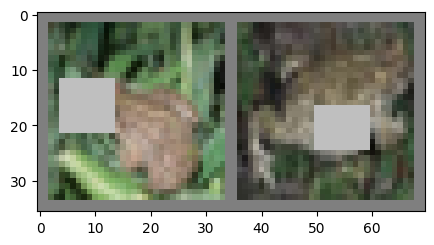

Frog 1: 0.994 | Frog 1 Patch: 0.784 | prediction: frog
Frog 2: 0.999 | Frog 2 Patch: 0.767 | prediction: frog


In [261]:
# do the same on frogs
frogs = images["frog"]
frog1 = float(torch.exp(torch.max(model(frogs[0].unsqueeze(0)))).detach().numpy())
frog2 = float(torch.exp(torch.max(model(frogs[1].unsqueeze(0)))).detach().numpy())

frog1_patch = apply_rectangular_patch(frogs[0], 10, 2, 10, 10)
frog2_patch = apply_rectangular_patch(frogs[1], 15, 14, 8, 10)

plt.figure(figsize=(5, 5))
imshow(torchvision.utils.make_grid(torch.tensor([frog1_patch, frog2_patch])))

frog1_patch_prob = float(
    torch.exp(torch.max(model(torch.tensor(frog1_patch).unsqueeze(0)))).detach().numpy()
)
frog1_patch_label = label_dict[
    np.argmax(model(torch.tensor(frog1_patch).unsqueeze(0)).detach().numpy())
]

frog2_patch_prob = float(
    torch.exp(torch.max(model(torch.tensor(frog2_patch).unsqueeze(0)))).detach().numpy()
)
frog2_patch_label = label_dict[
    np.argmax(model(torch.tensor(frog2_patch).unsqueeze(0)).detach().numpy())
]

print(
    f"Frog 1: {frog1:.3f} | Frog 1 Patch: {frog1_patch_prob:.3f} | prediction: {frog1_patch_label}"
)
print(
    f"Frog 2: {frog2:.3f} | Frog 2 Patch: {frog2_patch_prob:.3f} | prediction: {frog2_patch_label}"
)

The same behaviour as before. The model is quite robust to noise and patches.

# Final considerations

In this assignment, we built a CNN with four convolutional layers and up to 256 filters, employing advanced regularization techniques in order to squeeze all the potential out from the model, considering the limited computational resources.
The obtained model resulted being a good tradeoff between complexity and accuracy. State of the art models for this dataset are much more complex and deeper, and in order to acheive 7-10% more accuracy we would have needed to significantly increase the complexity of our architectue. 

We also tested the robustness of the model to noise, by progressively introducing grey patches on the images. Model revealed to be quite robust, and we experienced a drop of accuracy after several tries, and with relatively large patches. 


# References

1. [Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift - Sergey Ioffe, Christian Szegedy](https://storage.googleapis.com/pub-tools-public-publication-data/pdf/43442.pdf)
2. [K. He et al. Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385)